# Unsupervised Learning (Clustering Algorithm)

**Unsupervised learning** methods are applied to these daily representations
to identify latent behavioral–outcome regimes, such as stable days, intervention-heavy days,
and highly unstable high-risk days, without relying on predefined labels.

In [1]:
!uv pip install \
  "fastparquet>=2025.12.0" \
  "ipykernel>=7.2.0" \
  "llvmlite>=0.42" \
  "matplotlib>=3.10.8" \
  "numba>=0.59" \
  "numpy>=2.3.5" \
  "pandas==2.3.3" \
  "scikit-learn>=1.8.0" \
  "scipy>=1.17.0" \
  "seaborn>=0.13.2" \
  "umap-learn>=0.5.11"

Using Python 3.12.12 environment at: /Users/z.yang/playground/srh-stat-and-ml-exam/.venv
Audited 14 packages in 46ms


In [2]:
from pathlib import Path

ROOT_DIR = Path().resolve().parent
DATA_DIR = ROOT_DIR / "data"

In [3]:
import pandas as pd

pd.set_option("future.no_silent_downcasting", True)
pd.set_option('display.max_columns', None)

In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

## Solution

UMAP combined with DBSCAN is well suited for this unsupervised task because the daily diabetes features are high-dimensional, non-linear, and not expected to form spherical clusters. UMAP preserves local neighborhood structure while producing a compact low-dimensional representation, and DBSCAN can then identify clusters of arbitrary shape without requiring a predefined number of clusters, while naturally handling noise and outliers.

In [7]:
# ----------------------------------------
# UMAP + DBSCAN cluster
# ----------------------------------------
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import umap


def _build_feature_matrix(df: pd.DataFrame) -> pd.DataFrame:
    X = df.drop(columns=[c for c in ["id", "date"] if c in df.columns]).copy()

    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    bool_cols = [c for c in X.columns if pd.api.types.is_bool_dtype(X[c])]
    X = X[num_cols + bool_cols].copy()

    # bool -> 0/1 for distance-based methods
    for c in bool_cols:
        X[c] = X[c].astype(int)

    return X


def run_umap_dbscan(
    df: pd.DataFrame,
    # preprocessing
    fill_value: float = 0.0,
    run_plot: bool = False,
    # umap
    umap_dim_for_clustering: int = 10,
    umap_dim_for_plot: int = 2,
    n_neighbors: int = 30,
    min_dist: float = 0.0,
    metric: str = "euclidean",
    random_state: int = 42,
    # dbscan
    eps: float = 0.6,
    min_samples: int = 10,
):
    """
    Returns:
      df_out: df + cluster label (-1 noise)
      Zc: UMAP embedding used for clustering (n x umap_dim_for_clustering)
      Z2: UMAP 2D embedding for plotting (n x 2)
      counts: cluster size counts (including -1)
      sil: silhouette on non-noise points in Zc (if >=2 clusters)
    """
    df_out = df.copy()
    X = _build_feature_matrix(df_out)

    prep = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=fill_value)),
        ("scaler", StandardScaler()),
    ])
    Xs = prep.fit_transform(X)

    reducer_cluster = umap.UMAP(
        n_components=umap_dim_for_clustering,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
    )
    Zc = reducer_cluster.fit_transform(Xs)

    if run_plot:
        reducer_plot = umap.UMAP(
            n_components=umap_dim_for_plot,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=metric,
            random_state=random_state,
        )
        Z2 = reducer_plot.fit_transform(Xs)
    else:
        Z2 = None

    db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
    labels = db.fit_predict(Zc)

    df_out["cluster"] = labels

    counts = pd.Series(labels).value_counts().sort_index()
    noise_frac = float((labels == -1).mean())
    n_clusters = int(len([k for k in counts.index if k != -1]))

    sil = np.nan
    mask = labels != -1
    if mask.sum() > 10:
        uniq = np.unique(labels[mask])
        if uniq.size >= 2:
            sil = silhouette_score(Zc[mask], labels[mask])

    print(f"DBSCAN clusters (excluding noise): {n_clusters}")
    print(f"Noise fraction: {noise_frac:.3f}")
    print("Cluster counts:\n", counts)

    return df_out, Zc, Z2, counts, sil

In [10]:
# ----------------------------------------
# Search for best parameter `eps`
# ----------------------------------------
def scan_eps(
    df: pd.DataFrame,
    eps_list=(0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0),
    min_samples: int = 10,
    umap_dim_for_clustering: int = 10,
    n_neighbors: int = 30,
    min_dist: float = 0.0,
    random_state: int = 42,
):
    rows = []
    for eps in eps_list:
        df_out, Zc, Z2, counts, sil = run_umap_dbscan(
            df,
            umap_dim_for_clustering=umap_dim_for_clustering,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=random_state,
            eps=eps,
            min_samples=min_samples,
        )
        n_clusters = (counts.index != -1).sum()
        noise_frac = float((df_out["cluster"] == -1).mean())
        rows.append({"eps": eps, "min_samples": min_samples, "n_clusters": int(n_clusters), "noise_frac": noise_frac, "silhouette": sil})
    return pd.DataFrame(rows).sort_values(["n_clusters", "noise_frac"])


daily_df = pd.read_parquet(DATA_DIR / "processed" / "unsupervised" / "diabetes_daily_features.parquet")

# Fill missing values
for c in daily_df.columns:
    if c.endswith("_flag"):
        daily_df[c] = (
            daily_df[c]
            .astype("boolean")   # 显式 dtype，避免 silent downcast
            .fillna(False)
            .astype(bool)
        )

    elif c.endswith("_count"):
        daily_df[c] = (
            daily_df[c]
            .fillna(0)
            .astype(int)
        )

    elif c not in ["id", "date"]:
        # 其余统计值列（数值）
        daily_df[c] = daily_df[c].fillna(0)

grid = scan_eps(
    daily_df,
    eps_list=[0.1, 0.5, 1.0, 5.0, 10.0],
    min_samples=10)
display(grid)

DBSCAN clusters (excluding noise): 62
Noise fraction: 0.400
Cluster counts:
 -1     1351
 0       18
 1       46
 2       12
 3       46
       ... 
 57      28
 58      22
 59      61
 60      24
 61      11
Name: count, Length: 63, dtype: int64
DBSCAN clusters (excluding noise): 12
Noise fraction: 0.000
Cluster counts:
 -1        1
 0      907
 1     1252
 2      137
 3       60
 4       51
 5      216
 6       36
 7       34
 8       76
 9      113
 10     362
 11     133
Name: count, dtype: int64
DBSCAN clusters (excluding noise): 6
Noise fraction: 0.000
Cluster counts:
 0    1321
1    1288
2      51
3     110
4     113
5     495
Name: count, dtype: int64
DBSCAN clusters (excluding noise): 2
Noise fraction: 0.000
Cluster counts:
 0    2883
1     495
Name: count, dtype: int64
DBSCAN clusters (excluding noise): 1
Noise fraction: 0.000
Cluster counts:
 0    3378
Name: count, dtype: int64


,eps,min_samples,n_clusters,noise_frac,silhouette
4,10.0,10,1,0.000000,NaN
3,5.0,10,2,0.000000,0.654297
2,1.0,10,6,0.000000,0.430593
1,0.5,10,12,0.000296,0.257353
0,0.1,10,62,0.399941,0.725216


In [11]:
# ----------------------------------------
# Get result by the best parameters (Considering n_clusters, noise_frac, and silhouette together)
# ----------------------------------------
df_db, Zc, Z2, counts, sil = run_umap_dbscan(
    daily_df,
    run_plot=True,
    eps=1.0,
    min_samples=10,
)

print("Silhouette:", sil)
print("Cluster counts:")
print(counts)

DBSCAN clusters (excluding noise): 6
Noise fraction: 0.000
Cluster counts:
 0    1321
1    1288
2      51
3     110
4     113
5     495
Name: count, dtype: int64
Silhouette: 0.43059346079826355
Cluster counts:
0    1321
1    1288
2      51
3     110
4     113
5     495
Name: count, dtype: int64


In [12]:
# ----------------------------------------
# Calculate the features for each cluster
# ----------------------------------------
key_features = [
    # glycemic level & variability
    "bg_all_mean",
    "bg_all_std",
    "bg_all_range",

    # treatment intensity
    "ins_all_sum",
    "ins_all_count",

    # monitoring / activity
    "bg_all_count",
    "n_events",
    "active_span_minutes",

    # events / risk indicators
    "meal_events_count",
    "exercise_events_count",
    "hypo_flag",
]

key_features = [c for c in key_features if c in df_db.columns]

cluster_summary = (
    df_db
    .groupby("cluster")[key_features]
    .mean(numeric_only=True)
    .sort_index()
)

cluster_sizes = df_db["cluster"].value_counts().sort_index()
cluster_summary.insert(0, "cluster_size", cluster_sizes.values)
cluster_summary_rounded = cluster_summary.round(3)
cluster_summary_rounded

,cluster_size,bg_all_mean,bg_all_std,bg_all_range,ins_all_sum,ins_all_count,bg_all_count,n_events,active_span_minutes,meal_events_count,exercise_events_count,hypo_flag
cluster,,,,,,,,,,,,
0,1321,157.827,45.228,90.793,35.323,3.338,3.241,6.642,715.333,0.030,0.004,0.018
1,1288,155.187,69.691,138.519,29.599,3.765,3.311,7.636,829.113,0.226,0.047,0.158
2,51,208.082,95.808,214.216,38.843,4.706,4.294,9.353,898.549,0.118,0.059,0.059
3,110,173.849,76.457,162.227,28.209,4.127,3.782,9.955,845.445,0.709,0.918,0.191
4,113,126.664,60.101,129.504,21.752,3.062,3.903,8.690,840.575,0.159,1.115,0.133
5,495,172.942,65.083,143.879,46.329,4.248,3.949,8.305,911.737,0.079,0.000,0.028


In [13]:
# ----------------------------------------
# A heuristic for interpreting the risk level of each cluster
# ----------------------------------------
risk_score = (
    cluster_summary["bg_all_std"]
    + 0.5 * cluster_summary["bg_all_range"]
    + 0.2 * cluster_summary["ins_all_sum"]
    + 5.0 * cluster_summary["hypo_flag"]
)

cluster_summary["risk_score"] = risk_score
cluster_summary.sort_values("risk_score", ascending=False)

,cluster_size,bg_all_mean,bg_all_std,bg_all_range,ins_all_sum,ins_all_count,bg_all_count,n_events,active_span_minutes,meal_events_count,exercise_events_count,hypo_flag,risk_score
cluster,,,,,,,,,,,,,
2,51,208.081839,95.808054,214.215686,38.843137,4.705882,4.294118,9.352941,898.549020,0.117647,0.058824,0.058824,210.978643
3,110,173.848636,76.456929,162.227273,28.209091,4.127273,3.781818,9.954545,845.445455,0.709091,0.918182,0.190909,164.166929
5,495,172.942222,65.083197,143.878788,46.329293,4.248485,3.949495,8.305051,911.737374,0.078788,0.000000,0.028283,146.429864
1,1288,155.186511,69.690567,138.518634,29.599379,3.764752,3.310559,7.635870,829.112578,0.225932,0.047360,0.157609,145.657803
4,113,126.663717,60.101444,129.504425,21.752212,3.061947,3.902655,8.690265,840.575221,0.159292,1.115044,0.132743,129.867816
0,1321,157.826729,45.227615,90.793338,35.322861,3.338380,3.240727,6.641938,715.333081,0.030280,0.003785,0.018168,97.779697


## Conclusion

Daily feature vectors were analyzed using **UMAP** for dimensionality reduction followed by **DBSCAN** for clustering.
Model selection jointly considered the number of clusters, noise fraction, and Silhouette score.

With `eps = 1.0` and `min_samples = 10`, DBSCAN identified **6 clusters** with **near-zero noise**
and a **Silhouette score of approximately 0.43**, indicating a well-separated structure.
The clusters differ systematically in glucose level and variability, insulin usage, event frequency,
and daily activity span, suggesting distinct behavioral–outcome regimes
such as stable days, intervention-heavy days, and more volatile patterns.

| Cluster <br /> (Desc by Risk Level) | Name                                   | Interpretation                                                                                                                                                 |
|------------------------------------:|----------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|
|                                   2 | Severely unstable, high-risk days      | Extremely high glucose levels and variability with frequent corrective interventions, representing days of severe instability and elevated clinical risk.      |
|                                   3 | Behavior-driven high-variability days  | Pronounced glucose fluctuations strongly associated with meal and exercise events, often accompanied by hypoglycemic symptoms.                                 |
|                                   5 | Correction-heavy hyperglycemic days    | Persistently elevated glucose levels with intensive insulin usage, indicating frequent corrective dosing rather than acute instability.                        |
|                                   1 | Moderately unstable routine days       | Typical daily patterns with moderate glucose variability and occasional risk indicators, reflecting routine but imperfect glycemic control.                    |
|                                   4 | Exercise-associated lower-glucose days | Lower average glucose levels combined with frequent exercise events, suggesting a physically active regime with moderate variability.                          |
|                                   0 | Stable, well-controlled days           | Low glycemic variability and narrow glucose range with few events and limited intervention, indicating relatively stable and well-controlled daily management. |


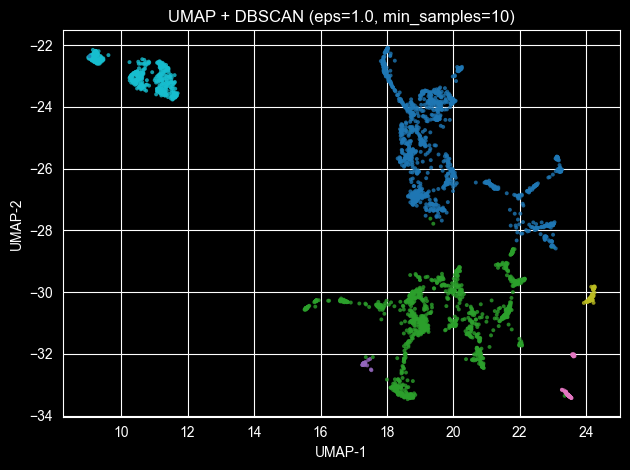

In [14]:
# ----------------------------------------
# Plotting
# ----------------------------------------
import matplotlib.pyplot as plt
import numpy as np

labels = df_db["cluster"].values

# 噪声点单独画
mask_noise = labels == -1
mask_cluster = labels != -1

plt.scatter(
    Z2[mask_cluster, 0],
    Z2[mask_cluster, 1],
    c=labels[mask_cluster],
    s=8,
    cmap="tab10",
    alpha=0.8,
    linewidths=0
)

if mask_noise.any():
    plt.scatter(
        Z2[mask_noise, 0],
        Z2[mask_noise, 1],
        c="lightgray",
        s=6,
        alpha=0.5,
        label="noise"
    )

plt.title("UMAP + DBSCAN (eps=1.0, min_samples=10)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()